# Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import datetime as datetime
from math import isclose
from collections import Counter
import multiprocessing
import re
# Network libary
#import networkit as nk
import networkx as nx
from graph_tool.all import *
import stellargraph as sg
from stellargraph import StellarGraph, datasets
from stellargraph.datasets import IAEnronEmployees
from stellargraph.data import EdgeSplitter
from stellargraph import IndexedArray

# sklearn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from stellargraph.mapper import FullBatchLinkGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN, LinkEmbedding
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification
from tensorflow import keras


2023-11-11 19:21:51.059126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 19:21:51.510635: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 19:21:52.394296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-11 19:21:52.394401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

# Load Data

In [2]:
loaded = np.load("/home/rh/Arbeitsraum/bitbucket/share/SLMI2/data/2022_6_2_law_500.npz",allow_pickle=True)


# Load train and test

In [3]:

#loaded = np.load("/home/rh/law_keiji_dyn_savez.npz",allow_pickle=True)
print(loaded.files)
edges_train = loaded["arr_0"]
labels_train = loaded["arr_1"]
edges_valid = loaded["arr_2"]
labels_valid = loaded["arr_3"]
edges_test = loaded["arr_4"]
labels_test = loaded["arr_5"]
features = loaded["arr_6"]
df_node2cnt = pd.DataFrame(loaded["arr_7"])

df_node2cnt.columns = ["index","node","cnt"]

node2index = dict()
for i in range(len(df_node2cnt)):
    node2index.update({df_node2cnt["node"].iloc[i]: df_node2cnt["index"].iloc[i]})
    

df_train_0 = pd.DataFrame(edges_train)
df_train_0[2] = labels_train
cond = df_train_0[2] == 1
df_train_1 = df_train_0.loc[cond].copy()
df_train = df_train_1[[0,1]].copy()
df_train.columns = ["source","target"]


df_train_0.columns = ["source","target","label"]

#df_train["source"] = df_train["source"].map(node2index)
#df_train["target"] = df_train["target"].map(node2index)
#df_train_0["source"] = df_train_0["source"].map(node2index)
#df_train_0["target"] = df_train_0["target"].map(node2index)

df_valid_0 = pd.DataFrame(edges_valid)
df_valid_0[2] = labels_valid
cond = df_valid_0[2] == 1
df_valid_1 = df_valid_0.loc[cond].copy()
df_valid = df_valid_1[[0,1]].copy()
df_valid.columns = ["source","target"]
df_valid_0.columns = ["source","target","label"]


#df_valid["source"] = df_valid["source"].map(node2index)
#df_valid["target"] = df_valid["target"].map(node2index)
#df_valid_0["source"] = df_valid_0["source"].map(node2index)
#df_valid_0["target"] = df_valid_0["target"].map(node2index)

df_test_0 = pd.DataFrame(edges_test)
df_test_0[2] = labels_test
cond = df_test_0[2] == 1
df_test_1 = df_test_0.loc[cond].copy()
df_test = df_test_1[[0,1]].copy()
df_test.columns = ["source","target"]
df_test_0.columns = ["source","target","label"]


#df_test["source"] = df_test["source"].map(node2index)
#df_test["target"] = df_test["target"].map(node2index)
#df_test_0["source"] = df_test_0["source"].map(node2index)
#df_test_0["target"] = df_test_0["target"].map(node2index)


df_node2cnt["node"] = df_node2cnt["node"].astype(str)
indexed_array = IndexedArray(features, index=list(df_node2cnt["node"]))
#indexed_array = IndexedArray( index=list(df_node2cnt["node"]))
tmp_nodes = list(set(df_train["source"]))
tmp_nodes.extend(list(set(df_train["target"])))
tmp_nodes = list(set(tmp_nodes))

['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6', 'arr_7']


# Create Stellar Objects

In [4]:
df_train["source"] = df_train["source"].astype(str)
df_train["target"] = df_train["target"].astype(str)

df_test["source"] = df_test["source"].astype(str)
df_test["target"] = df_test["target"].astype(str)

graph_train = StellarGraph(nodes=indexed_array,edges=df_train)
graph_test = StellarGraph(nodes=indexed_array,edges=df_test)
#print(graph_train.info())
#graph_test = StellarGraph(nodes=df_nodes,edges=df_test)
#print(graph_test.info())
# weight_
#
#graph_test = StellarGraph(edges=df_test)
#graph = StellarGraph(edges=df_edges_2[["source","target","weight"]])
#edge_splitter_test = EdgeSplitter(graph)
#graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
#    p=0.1, method="global")
#print(graph_test.info())
#df_test = pd.DataFrame(graph_test.edges())
#len(df_test)
#X = graph_test.to_adjacency_matrix()
#edge_splitter_train = EdgeSplitter(graph_test, graph)
#graph_train, examples, labels = edge_splitter_train.train_test_split(
#    p=0.1, method="global")
#(examples_train,examples_model_selection,labels_train,
#    labels_model_selection,) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)
#print(graph_train.info())
#df_train = pd.DataFrame(graph_train.edges())

In [5]:
print(graph_train.info())

StellarGraph: Undirected multigraph
 Nodes: 3521, Edges: 51430

 Node types:
  default: [3521]
    Features: float64 vector, length 5677
    Edge types: default-default->default

 Edge types:
    default-default->default: [51430]
        Weights: all 1 (default)
        Features: none


In [6]:
print(graph_test.info())

StellarGraph: Undirected multigraph
 Nodes: 3521, Edges: 17378

 Node types:
  default: [3521]
    Features: float64 vector, length 5677
    Edge types: default-default->default

 Edge types:
    default-default->default: [17378]
        Weights: all 1 (default)
        Features: none


# Run

In [7]:
train_gen = FullBatchLinkGenerator(graph_train, method="gcn")
train_flow = train_gen.flow(edges_train, labels_train)
test_gen = FullBatchLinkGenerator(graph_test, method="gcn")
test_flow = train_gen.flow(edges_test, labels_test)

gcn = GCN(
    layer_sizes=[250], activations=["relu"], 
    generator=train_gen, dropout=0.2
)

x_inp, x_out = gcn.in_out_tensors()
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.binary_crossentropy
)

#model.compile(loss='categorical_crossentropy', optimizer='adadelta',metrics=['acc'])
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
print(init_train_metrics)
#for name, val in zip(model.metrics_names, init_train_metrics):
#   print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
#for name, val in zip(model.metrics_names, init_test_metrics):
#    print("\t{}: {:0.4f}".format(name, val))
print(init_test_metrics)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 200ms/step - loss: 1.6108

Train Set Metrics of the initial (untrained) model:
1.598541021347046

Test Set Metrics of the initial (untrained) model:
1.6107686758041382


# Run

In [8]:
%%time
epochs = 1000
history = model.fit(
    train_flow, epochs=epochs, 
     validation_data=test_flow, verbose=2, shuffle=False)

Epoch 1/1000
1/1 - 1s - loss: 1.5963 - val_loss: 0.6400 - 1s/epoch - 1s/step
Epoch 2/1000
1/1 - 1s - loss: 0.6372 - val_loss: 0.4812 - 583ms/epoch - 583ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.4785 - val_loss: 0.4292 - 427ms/epoch - 427ms/step
Epoch 4/1000
1/1 - 1s - loss: 0.4267 - val_loss: 0.4292 - 512ms/epoch - 512ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.4267 - val_loss: 0.4572 - 416ms/epoch - 416ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.4551 - val_loss: 0.4936 - 450ms/epoch - 450ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.4919 - val_loss: 0.5231 - 431ms/epoch - 431ms/step
Epoch 8/1000
1/1 - 0s - loss: 0.5211 - val_loss: 0.5380 - 408ms/epoch - 408ms/step
Epoch 9/1000
1/1 - 0s - loss: 0.5362 - val_loss: 0.5383 - 438ms/epoch - 438ms/step
Epoch 10/1000
1/1 - 0s - loss: 0.5369 - val_loss: 0.5288 - 423ms/epoch - 423ms/step
Epoch 11/1000
1/1 - 0s - loss: 0.5270 - val_loss: 0.5144 - 425ms/epoch - 425ms/step
Epoch 12/1000
1/1 - 0s - loss: 0.5123 - val_loss: 0.4998 - 435ms/epoch - 435ms/step
Epoch 1

Epoch 99/1000
1/1 - 0s - loss: 0.4064 - val_loss: 0.4081 - 422ms/epoch - 422ms/step
Epoch 100/1000
1/1 - 0s - loss: 0.4062 - val_loss: 0.4079 - 431ms/epoch - 431ms/step
Epoch 101/1000
1/1 - 0s - loss: 0.4060 - val_loss: 0.4077 - 427ms/epoch - 427ms/step
Epoch 102/1000
1/1 - 0s - loss: 0.4057 - val_loss: 0.4075 - 450ms/epoch - 450ms/step
Epoch 103/1000
1/1 - 0s - loss: 0.4056 - val_loss: 0.4072 - 414ms/epoch - 414ms/step
Epoch 104/1000
1/1 - 0s - loss: 0.4054 - val_loss: 0.4070 - 435ms/epoch - 435ms/step
Epoch 105/1000
1/1 - 0s - loss: 0.4051 - val_loss: 0.4068 - 426ms/epoch - 426ms/step
Epoch 106/1000
1/1 - 0s - loss: 0.4049 - val_loss: 0.4066 - 436ms/epoch - 436ms/step
Epoch 107/1000
1/1 - 0s - loss: 0.4047 - val_loss: 0.4064 - 435ms/epoch - 435ms/step
Epoch 108/1000
1/1 - 0s - loss: 0.4045 - val_loss: 0.4062 - 427ms/epoch - 427ms/step
Epoch 109/1000
1/1 - 0s - loss: 0.4043 - val_loss: 0.4060 - 428ms/epoch - 428ms/step
Epoch 110/1000
1/1 - 0s - loss: 0.4041 - val_loss: 0.4057 - 446ms/

Epoch 196/1000
1/1 - 0s - loss: 0.3847 - val_loss: 0.3851 - 447ms/epoch - 447ms/step
Epoch 197/1000
1/1 - 0s - loss: 0.3845 - val_loss: 0.3849 - 430ms/epoch - 430ms/step
Epoch 198/1000
1/1 - 0s - loss: 0.3842 - val_loss: 0.3846 - 419ms/epoch - 419ms/step
Epoch 199/1000
1/1 - 0s - loss: 0.3839 - val_loss: 0.3844 - 425ms/epoch - 425ms/step
Epoch 200/1000
1/1 - 0s - loss: 0.3837 - val_loss: 0.3841 - 421ms/epoch - 421ms/step
Epoch 201/1000
1/1 - 0s - loss: 0.3834 - val_loss: 0.3839 - 441ms/epoch - 441ms/step
Epoch 202/1000
1/1 - 0s - loss: 0.3832 - val_loss: 0.3836 - 416ms/epoch - 416ms/step
Epoch 203/1000
1/1 - 0s - loss: 0.3830 - val_loss: 0.3834 - 441ms/epoch - 441ms/step
Epoch 204/1000
1/1 - 0s - loss: 0.3828 - val_loss: 0.3831 - 425ms/epoch - 425ms/step
Epoch 205/1000
1/1 - 0s - loss: 0.3825 - val_loss: 0.3829 - 436ms/epoch - 436ms/step
Epoch 206/1000
1/1 - 0s - loss: 0.3822 - val_loss: 0.3826 - 439ms/epoch - 439ms/step
Epoch 207/1000
1/1 - 0s - loss: 0.3821 - val_loss: 0.3824 - 427ms

Epoch 293/1000
1/1 - 0s - loss: 0.3548 - val_loss: 0.3560 - 428ms/epoch - 428ms/step
Epoch 294/1000
1/1 - 0s - loss: 0.3542 - val_loss: 0.3555 - 450ms/epoch - 450ms/step
Epoch 295/1000
1/1 - 0s - loss: 0.3541 - val_loss: 0.3551 - 423ms/epoch - 423ms/step
Epoch 296/1000
1/1 - 0s - loss: 0.3534 - val_loss: 0.3546 - 427ms/epoch - 427ms/step
Epoch 297/1000
1/1 - 0s - loss: 0.3532 - val_loss: 0.3542 - 410ms/epoch - 410ms/step
Epoch 298/1000
1/1 - 0s - loss: 0.3525 - val_loss: 0.3538 - 454ms/epoch - 454ms/step
Epoch 299/1000
1/1 - 0s - loss: 0.3524 - val_loss: 0.3533 - 436ms/epoch - 436ms/step
Epoch 300/1000
1/1 - 0s - loss: 0.3517 - val_loss: 0.3529 - 415ms/epoch - 415ms/step
Epoch 301/1000
1/1 - 0s - loss: 0.3511 - val_loss: 0.3524 - 434ms/epoch - 434ms/step
Epoch 302/1000
1/1 - 0s - loss: 0.3508 - val_loss: 0.3520 - 438ms/epoch - 438ms/step
Epoch 303/1000
1/1 - 0s - loss: 0.3504 - val_loss: 0.3515 - 418ms/epoch - 418ms/step
Epoch 304/1000
1/1 - 0s - loss: 0.3497 - val_loss: 0.3511 - 417ms

Epoch 390/1000
1/1 - 0s - loss: 0.3228 - val_loss: 0.3272 - 420ms/epoch - 420ms/step
Epoch 391/1000
1/1 - 0s - loss: 0.3224 - val_loss: 0.3271 - 418ms/epoch - 418ms/step
Epoch 392/1000
1/1 - 0s - loss: 0.3226 - val_loss: 0.3271 - 414ms/epoch - 414ms/step
Epoch 393/1000
1/1 - 0s - loss: 0.3228 - val_loss: 0.3270 - 427ms/epoch - 427ms/step
Epoch 394/1000
1/1 - 0s - loss: 0.3226 - val_loss: 0.3268 - 424ms/epoch - 424ms/step
Epoch 395/1000
1/1 - 0s - loss: 0.3222 - val_loss: 0.3266 - 410ms/epoch - 410ms/step
Epoch 396/1000
1/1 - 0s - loss: 0.3225 - val_loss: 0.3265 - 435ms/epoch - 435ms/step
Epoch 397/1000
1/1 - 0s - loss: 0.3221 - val_loss: 0.3262 - 432ms/epoch - 432ms/step
Epoch 398/1000
1/1 - 0s - loss: 0.3218 - val_loss: 0.3259 - 442ms/epoch - 442ms/step
Epoch 399/1000
1/1 - 0s - loss: 0.3217 - val_loss: 0.3257 - 456ms/epoch - 456ms/step
Epoch 400/1000
1/1 - 0s - loss: 0.3210 - val_loss: 0.3255 - 441ms/epoch - 441ms/step
Epoch 401/1000
1/1 - 0s - loss: 0.3210 - val_loss: 0.3253 - 426ms

Epoch 487/1000
1/1 - 0s - loss: 0.3107 - val_loss: 0.3162 - 416ms/epoch - 416ms/step
Epoch 488/1000
1/1 - 0s - loss: 0.3104 - val_loss: 0.3162 - 413ms/epoch - 413ms/step
Epoch 489/1000
1/1 - 0s - loss: 0.3105 - val_loss: 0.3161 - 409ms/epoch - 409ms/step
Epoch 490/1000
1/1 - 0s - loss: 0.3106 - val_loss: 0.3160 - 413ms/epoch - 413ms/step
Epoch 491/1000
1/1 - 0s - loss: 0.3103 - val_loss: 0.3158 - 413ms/epoch - 413ms/step
Epoch 492/1000
1/1 - 0s - loss: 0.3103 - val_loss: 0.3157 - 425ms/epoch - 425ms/step
Epoch 493/1000
1/1 - 0s - loss: 0.3103 - val_loss: 0.3156 - 415ms/epoch - 415ms/step
Epoch 494/1000
1/1 - 0s - loss: 0.3098 - val_loss: 0.3155 - 436ms/epoch - 436ms/step
Epoch 495/1000
1/1 - 0s - loss: 0.3098 - val_loss: 0.3156 - 404ms/epoch - 404ms/step
Epoch 496/1000
1/1 - 0s - loss: 0.3096 - val_loss: 0.3157 - 407ms/epoch - 407ms/step
Epoch 497/1000
1/1 - 0s - loss: 0.3098 - val_loss: 0.3152 - 427ms/epoch - 427ms/step
Epoch 498/1000
1/1 - 0s - loss: 0.3092 - val_loss: 0.3149 - 441ms

Epoch 584/1000
1/1 - 0s - loss: 0.3001 - val_loss: 0.3071 - 431ms/epoch - 431ms/step
Epoch 585/1000
1/1 - 0s - loss: 0.2996 - val_loss: 0.3072 - 412ms/epoch - 412ms/step
Epoch 586/1000
1/1 - 0s - loss: 0.2993 - val_loss: 0.3071 - 425ms/epoch - 425ms/step
Epoch 587/1000
1/1 - 0s - loss: 0.2997 - val_loss: 0.3070 - 408ms/epoch - 408ms/step
Epoch 588/1000
1/1 - 0s - loss: 0.2996 - val_loss: 0.3069 - 410ms/epoch - 410ms/step
Epoch 589/1000
1/1 - 0s - loss: 0.2995 - val_loss: 0.3068 - 404ms/epoch - 404ms/step
Epoch 590/1000
1/1 - 0s - loss: 0.2995 - val_loss: 0.3069 - 414ms/epoch - 414ms/step
Epoch 591/1000
1/1 - 0s - loss: 0.2991 - val_loss: 0.3068 - 440ms/epoch - 440ms/step
Epoch 592/1000
1/1 - 0s - loss: 0.2990 - val_loss: 0.3065 - 405ms/epoch - 405ms/step
Epoch 593/1000
1/1 - 0s - loss: 0.2990 - val_loss: 0.3064 - 420ms/epoch - 420ms/step
Epoch 594/1000
1/1 - 0s - loss: 0.2988 - val_loss: 0.3062 - 418ms/epoch - 418ms/step
Epoch 595/1000
1/1 - 0s - loss: 0.2984 - val_loss: 0.3060 - 417ms

Epoch 681/1000
1/1 - 0s - loss: 0.2931 - val_loss: 0.3003 - 415ms/epoch - 415ms/step
Epoch 682/1000
1/1 - 0s - loss: 0.2930 - val_loss: 0.3002 - 428ms/epoch - 428ms/step
Epoch 683/1000
1/1 - 0s - loss: 0.2930 - val_loss: 0.3001 - 414ms/epoch - 414ms/step
Epoch 684/1000
1/1 - 0s - loss: 0.2930 - val_loss: 0.3002 - 424ms/epoch - 424ms/step
Epoch 685/1000
1/1 - 0s - loss: 0.2930 - val_loss: 0.3004 - 433ms/epoch - 433ms/step
Epoch 686/1000
1/1 - 0s - loss: 0.2929 - val_loss: 0.3006 - 450ms/epoch - 450ms/step
Epoch 687/1000
1/1 - 0s - loss: 0.2932 - val_loss: 0.3009 - 432ms/epoch - 432ms/step
Epoch 688/1000
1/1 - 0s - loss: 0.2936 - val_loss: 0.3013 - 422ms/epoch - 422ms/step
Epoch 689/1000
1/1 - 0s - loss: 0.2936 - val_loss: 0.3018 - 411ms/epoch - 411ms/step
Epoch 690/1000
1/1 - 0s - loss: 0.2939 - val_loss: 0.3018 - 421ms/epoch - 421ms/step
Epoch 691/1000
1/1 - 0s - loss: 0.2942 - val_loss: 0.3021 - 415ms/epoch - 415ms/step
Epoch 692/1000
1/1 - 0s - loss: 0.2940 - val_loss: 0.3019 - 413ms

Epoch 778/1000
1/1 - 0s - loss: 0.2873 - val_loss: 0.2953 - 408ms/epoch - 408ms/step
Epoch 779/1000
1/1 - 0s - loss: 0.2865 - val_loss: 0.2951 - 418ms/epoch - 418ms/step
Epoch 780/1000
1/1 - 0s - loss: 0.2868 - val_loss: 0.2950 - 423ms/epoch - 423ms/step
Epoch 781/1000
1/1 - 0s - loss: 0.2867 - val_loss: 0.2950 - 410ms/epoch - 410ms/step
Epoch 782/1000
1/1 - 0s - loss: 0.2865 - val_loss: 0.2950 - 419ms/epoch - 419ms/step
Epoch 783/1000
1/1 - 0s - loss: 0.2862 - val_loss: 0.2949 - 411ms/epoch - 411ms/step
Epoch 784/1000
1/1 - 0s - loss: 0.2863 - val_loss: 0.2949 - 409ms/epoch - 409ms/step
Epoch 785/1000
1/1 - 0s - loss: 0.2861 - val_loss: 0.2948 - 419ms/epoch - 419ms/step
Epoch 786/1000
1/1 - 0s - loss: 0.2866 - val_loss: 0.2949 - 429ms/epoch - 429ms/step
Epoch 787/1000
1/1 - 0s - loss: 0.2865 - val_loss: 0.2946 - 427ms/epoch - 427ms/step
Epoch 788/1000
1/1 - 0s - loss: 0.2864 - val_loss: 0.2964 - 411ms/epoch - 411ms/step
Epoch 789/1000
1/1 - 0s - loss: 0.2871 - val_loss: 0.2988 - 420ms

Epoch 875/1000
1/1 - 0s - loss: 0.2827 - val_loss: 0.2921 - 439ms/epoch - 439ms/step
Epoch 876/1000
1/1 - 0s - loss: 0.2826 - val_loss: 0.2923 - 442ms/epoch - 442ms/step
Epoch 877/1000
1/1 - 0s - loss: 0.2829 - val_loss: 0.2923 - 411ms/epoch - 411ms/step
Epoch 878/1000
1/1 - 0s - loss: 0.2828 - val_loss: 0.2925 - 438ms/epoch - 438ms/step
Epoch 879/1000
1/1 - 0s - loss: 0.2834 - val_loss: 0.2924 - 440ms/epoch - 440ms/step
Epoch 880/1000
1/1 - 0s - loss: 0.2834 - val_loss: 0.2925 - 421ms/epoch - 421ms/step
Epoch 881/1000
1/1 - 0s - loss: 0.2833 - val_loss: 0.2920 - 425ms/epoch - 425ms/step
Epoch 882/1000
1/1 - 0s - loss: 0.2838 - val_loss: 0.2919 - 423ms/epoch - 423ms/step
Epoch 883/1000
1/1 - 0s - loss: 0.2829 - val_loss: 0.2916 - 428ms/epoch - 428ms/step
Epoch 884/1000
1/1 - 0s - loss: 0.2829 - val_loss: 0.2915 - 441ms/epoch - 441ms/step
Epoch 885/1000
1/1 - 0s - loss: 0.2828 - val_loss: 0.2913 - 428ms/epoch - 428ms/step
Epoch 886/1000
1/1 - 0s - loss: 0.2827 - val_loss: 0.2907 - 410ms

Epoch 972/1000
1/1 - 0s - loss: 0.2756 - val_loss: 0.2860 - 418ms/epoch - 418ms/step
Epoch 973/1000
1/1 - 0s - loss: 0.2755 - val_loss: 0.2862 - 421ms/epoch - 421ms/step
Epoch 974/1000
1/1 - 0s - loss: 0.2756 - val_loss: 0.2862 - 410ms/epoch - 410ms/step
Epoch 975/1000
1/1 - 0s - loss: 0.2756 - val_loss: 0.2861 - 425ms/epoch - 425ms/step
Epoch 976/1000
1/1 - 0s - loss: 0.2756 - val_loss: 0.2861 - 407ms/epoch - 407ms/step
Epoch 977/1000
1/1 - 0s - loss: 0.2754 - val_loss: 0.2860 - 416ms/epoch - 416ms/step
Epoch 978/1000
1/1 - 0s - loss: 0.2754 - val_loss: 0.2859 - 415ms/epoch - 415ms/step
Epoch 979/1000
1/1 - 0s - loss: 0.2754 - val_loss: 0.2860 - 432ms/epoch - 432ms/step
Epoch 980/1000
1/1 - 0s - loss: 0.2758 - val_loss: 0.2861 - 421ms/epoch - 421ms/step
Epoch 981/1000
1/1 - 0s - loss: 0.2755 - val_loss: 0.2860 - 412ms/epoch - 412ms/step
Epoch 982/1000
1/1 - 0s - loss: 0.2755 - val_loss: 0.2857 - 412ms/epoch - 412ms/step
Epoch 983/1000
1/1 - 0s - loss: 0.2754 - val_loss: 0.2858 - 421ms

# Evaluate

In [9]:

train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)
print("\nTrain Set Metrics of the initial (untrained) model:")
print(init_train_metrics)
#for name, val in zip(model.metrics_names, init_train_metrics):
#   print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
#for name, val in zip(model.metrics_names, init_test_metrics):
#    print("\t{}: {:0.4f}".format(name, val))
print(init_test_metrics)

1/1 [==============================] - 0s 234ms/step - loss: 0.2855

Train Set Metrics of the initial (untrained) model:
1.598541021347046

Test Set Metrics of the initial (untrained) model:
1.6107686758041382


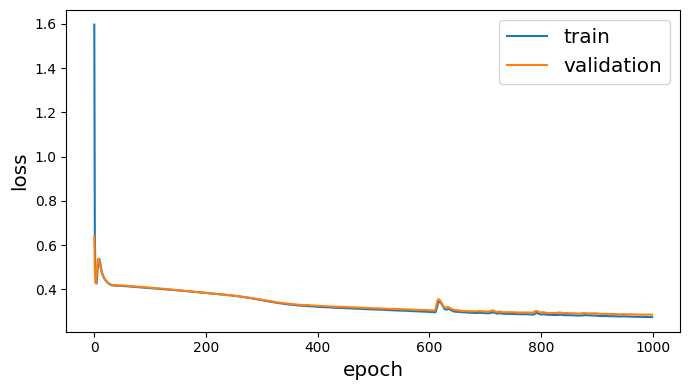

In [10]:
sg.utils.plot_history(history)

# Final Score

In [11]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve

predict_y = model.predict(test_flow)

fpr, tpr, thresholds = metrics.roc_curve(labels_test, predict_y[0,:])
auc = metrics.auc(fpr, tpr)
print(auc)
# Average precision score
average_precision = average_precision_score(labels_test, predict_y[0,:])
print(average_precision)
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(labels_test, predict_y[0,:])
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)
print(auc_precision_recall)

1/1 [==============================] - 0s 333ms/step
0.9037004097062782
0.6800407401993287
0.6800110483349524


# Save

In [12]:
df_pred = pd.DataFrame({"pred":predict_y[0,:]})
header = "./results/"
file_out = header + "GCN_pred.csv"
print(file_out)
df_pred.to_csv(file_out,index=False)
print(len(df_pred))
file_out_3 = header + "_df_node2cnt.csv"
df_node2cnt.to_csv(file_out_3,index=False)

./results/GCN_pred.csv
104268


# Get Embedding

In [13]:
embedding_model = keras.Model(inputs=x_inp, outputs=x_out)
generator = FullBatchNodeGenerator(graph_train, method="gcn")
all_nodes = list(df_node2cnt["node"])
all_gen = generator.flow(all_nodes)
emb = embedding_model.predict(all_gen)
X = emb.squeeze(0)
X.shape

file_out_2 = header +  "_GCN_node_emb.npz"
np.savez_compressed(file_out_2, X)

Using GCN (local pooling) filters...
1/1 [==============================] - 0s 260ms/step


# Load embedding

In [14]:
loaded = np.load(file_out_2)
X = loaded["arr_0"]

[None,
 Text(0.5, 0, '$X_1$'),
 Text(0, 0.5, '$X_2$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings')]

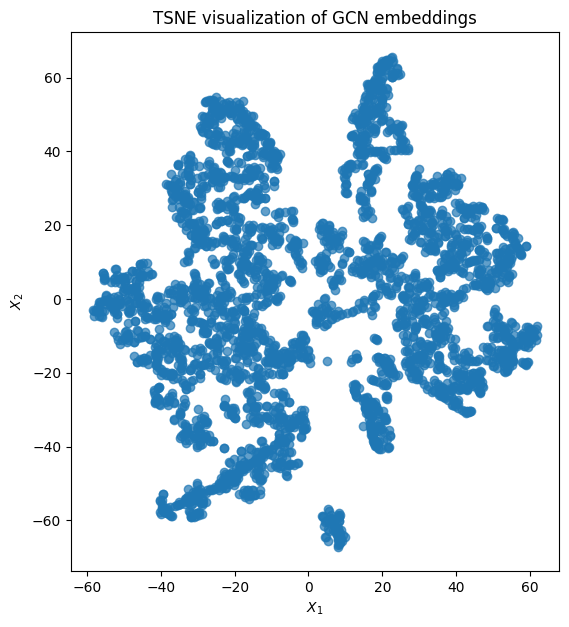

In [15]:

transform = TSNE  # or PCA
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    #c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings",
)